# Data cleaning and engineering

In [1]:
from ift6758.data.acquisition import NHLGameData

data_path_raw = './../../ift6758/data/json_raw/'
nhl_games_data = NHLGameData(data_path_raw)
for year in range(2016,2021):
    nhl_games_data.fetch_season(year)

Loading from cache file ./../../ift6758/data/json_raw/2016/2016-regular.pkl
Found 1230 regular games for season 2016-2017
Loading from cache file ./../../ift6758/data/json_raw/2016/2016-playoff.pkl
Found 102 playoff games for season 2016-2017
Loading from cache file ./../../ift6758/data/json_raw/2017/2017-regular.pkl
Found 1271 regular games for season 2017-2018
Loading from cache file ./../../ift6758/data/json_raw/2017/2017-playoff.pkl
Found 105 playoff games for season 2017-2018
Loading from cache file ./../../ift6758/data/json_raw/2018/2018-regular.pkl
Found 1271 regular games for season 2018-2019
Loading from cache file ./../../ift6758/data/json_raw/2018/2018-playoff.pkl
Found 105 playoff games for season 2018-2019
Loading from cache file ./../../ift6758/data/json_raw/2019/2019-regular.pkl
Found 1271 regular games for season 2019-2020
Loading from cache file ./../../ift6758/data/json_raw/2019/2019-playoff.pkl
Found 105 playoff games for season 2019-2020
Loading from cache file ./..

In [2]:
from ift6758.data.cleaning import DataCleaner

data_path_clean = './../../ift6758/data/json_clean/'
data_cleaner = DataCleaner(data_raw=nhl_games_data, data_path_clean=data_path_clean)
for year in range(2016,2021):
    data_cleaner.clean_season(year, keepPreviousEventInfo=True, includePowerPlay=False)

In [3]:
data_2016 = data_cleaner.get_cleaned_data(2016)
data_2016.sample(5)

,game_id,period,period_time,type,team,x,y,shooter,goalie,shot_type,empty_net,strength,opposite_team_side,prev_type,prev_x,prev_y,time_since_prev,distance_from_prev
45601,2016020752,1,240,SHOT,Arizona Coyotes,8.0,34.0,Oliver Ekman-Larsson,Peter Budaj,Slap Shot,False,None,right,MISSED_SHOT,-79.0,26.0,18.0,87.37
25666,2016020423,1,826,GOAL,Washington Capitals,-70.0,-23.0,Alex Ovechkin,Jacob Markstrom,Wrist Shot,False,Power Play,left,SHOT,-75.0,1.0,45.0,24.52
4004,2016020068,1,308,SHOT,Colorado Avalanche,69.0,2.0,Matt Duchene,Roberto Luongo,Snap Shot,False,None,right,GIVEAWAY,32.0,-9.0,47.0,38.60
6949,2016020116,2,720,SHOT,New Jersey Devils,-56.0,-32.0,Beau Bennett,Andrei Vasilevskiy,Wrist Shot,False,None,left,HIT,46.0,-40.0,10.0,102.31
61947,2016021016,3,802,SHOT,Carolina Hurricanes,-80.0,7.0,Lee Stempniak,Thomas Greiss,Tip-In,False,None,left,MISSED_SHOT,-69.0,2.0,27.0,12.08


In [4]:
from ift6758.features import FeatureEng
data_path_clean = './../../ift6758/data/json_clean/'
w = FeatureEng(data_path_clean)

In [5]:
df = w.features_2(2016,2021)
print(df.columns)
df.head()

Index(['game_id', 'period', 'game_seconds', 'x', 'y', 'shot_type', 'empty_net',
       'strength', 'prev_type', 'prev_x', 'prev_y', 'time_since_prev',
       'distance_from_prev', 'distance_goal', 'prev_distance_goal',
       'angle_shot', 'prev_angle_shot', 'bounce', 'angle_change', 'speed',
       'is_goal'],
      dtype='object')


,game_id,period,game_seconds,x,y,shot_type,empty_net,strength,prev_type,prev_x,...,time_since_prev,distance_from_prev,distance_goal,prev_distance_goal,angle_shot,prev_angle_shot,bounce,angle_change,speed,is_goal
0,2016020001,1,1271,-77.0,5.0,Wrist Shot,False,None,BLOCKED_SHOT,-61.0,...,1.0,17.09,13.93,31.02,21.03,20.77,True,0.26,17.09,0
1,2016020001,1,1373,86.0,13.0,Wrist Shot,False,None,GIVEAWAY,54.0,...,5.0,36.72,13.60,36.35,72.92,-7.91,False,0.00,7.34,0
2,2016020001,1,1441,23.0,-38.0,Wrist Shot,False,None,MISSED_SHOT,-72.0,...,18.0,102.32,77.03,162.00,-29.56,0.00,True,-29.56,5.68,0
3,2016020001,1,1486,33.0,-15.0,Slap Shot,False,None,MISSED_SHOT,77.0,...,19.0,45.88,58.94,13.15,-14.74,-8.75,True,-5.99,2.41,0
4,2016020001,1,1606,-34.0,28.0,Wrist Shot,False,None,HIT,47.0,...,16.0,81.22,62.61,141.16,26.57,13.94,False,0.00,5.08,0


#### Encoding categorical variables

In [6]:
# Convert categorical features to one-hot encoding
categorical_features = ['strength', 'shot_type', 'prev_type']
df = w.encodeCategories(df, categorical_features)
df.columns

Index(['game_id', 'period', 'game_seconds', 'x', 'y', 'empty_net', 'prev_x',
       'prev_y', 'time_since_prev', 'distance_from_prev', 'distance_goal',
       'prev_distance_goal', 'angle_shot', 'prev_angle_shot', 'bounce',
       'angle_change', 'speed', 'is_goal', 'strength_Power Play',
       'strength_Short Handed', 'shot_type_Deflected', 'shot_type_Slap Shot',
       'shot_type_Snap Shot', 'shot_type_Tip-In', 'shot_type_Wrap-around',
       'shot_type_Wrist Shot', 'prev_type_FACEOFF', 'prev_type_GIVEAWAY',
       'prev_type_GOAL', 'prev_type_HIT', 'prev_type_MISSED_SHOT',
       'prev_type_PENALTY', 'prev_type_SHOT', 'prev_type_TAKEAWAY'],
      dtype='object')

___

# Neural Network

#### Splitting the data

We won't need game_id here but maybe later when doing different data split considerations

In [7]:
# drop game_id
df = df.drop(['game_id'], axis=1)

#########

In [8]:
from ift6758.training import Net
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn as nn

In [9]:
X = df.drop('is_goal', axis=1)
y = df['is_goal']

# Splitting the dataset into the Training set and Test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Feature Scaling
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Converting to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train.values, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test.values, dtype=torch.float32)


In [10]:
from torch.utils.data import TensorDataset, DataLoader

# Create TensorDatasets for training and testing data
train_data = TensorDataset(X_train, y_train)
test_data = TensorDataset(X_test, y_test)

# Create DataLoaders
batch_size = 512
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch_size)

In [15]:
input_size = X_train.shape[1] # 32
output_size = 1

hidden_layer_sizes = [32, 16]
small_model = Net(input_size, hidden_layer_sizes, output_size)

hidden_layer_sizes = [64]
small_model2 = Net(input_size, hidden_layer_sizes, output_size)

hidden_layer_sizes = [64, 64]
small_model3 = Net(input_size, hidden_layer_sizes, output_size)

hidden_layer_sizes = [256, 128]
small_model4 = Net(input_size, hidden_layer_sizes, output_size)

hidden_layer_sizes = [256, 128, 64, 64, 32]
deeper_model = Net(input_size, hidden_layer_sizes, output_size)

hidden_layer_sizes = [512, 256, 128, 64, 32, 16]
deeper_model_bigger_layers = Net(input_size, hidden_layer_sizes, output_size)

criterion = nn.BCELoss()
num_epochs = 15

In [16]:
def train_mlp(num_epochs, model, criterion, optimizer, train_loader):
    train_losses = []

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        for X, y in train_loader:
            X = X.to(model.device)
            y = y.to(model.device)

            optimizer.zero_grad()
            output = model(X)
            loss = criterion(output, y.unsqueeze(1))
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * X.size(0)
        train_loss /= len(train_loader.dataset)
        train_losses.append(train_loss)

        print(f'Epoch: {epoch + 1} \tTraining Loss: {train_loss:.6f}')

    return train_losses

def test_mlp(model, criterion, test_loader):
    model.eval()
    test_loss = 0.0
    probabilities = []

    with torch.no_grad():
        for X, y in test_loader:
            X = X.to(model.device)
            y = y.to(model.device)

            outputs = model(X)
            loss = criterion(outputs, y.unsqueeze(1))

            test_loss += loss.item() * X.size(0)
            probabilities.extend(outputs.cpu().numpy()[:, 0])

    test_loss /= len(test_loader.dataset)
    print(f'Testing Loss: {test_loss:.6f}')

    return test_loss, probabilities

In [17]:
import os

def log(train_losses, test_losses, probabilities, model_name):
    path = './logs/' + model_name + '/'
    os.makedirs(path, exist_ok=True)
    torch.save(train_losses, path + model_name +'_train_losses.pt')
    torch.save(test_losses, path + model_name + '_test_losses.pt')
    torch.save(probabilities, path + model_name + '_probabilities.pt')

In [18]:
models_dict = {}

In [19]:
print('====== small_model ======')
optimizer = torch.optim.Adam(small_model.parameters(), lr=0.001)
train_losses = train_mlp(num_epochs, small_model, criterion, optimizer, train_loader)
test_losses, probabilities = test_mlp(small_model, criterion, test_loader)
log(train_losses, test_losses, probabilities, 'small_model')
models_dict['small_model'] = probabilities

print('====== small_model2 ======')
optimizer = torch.optim.Adam(small_model2.parameters(), lr=0.001)
train_losses = train_mlp(num_epochs, small_model2, criterion, optimizer, train_loader)
test_losses, probabilities = test_mlp(small_model2, criterion, test_loader)
log(train_losses, test_losses, probabilities, 'small_model2')
models_dict['small_model2'] = probabilities

print('====== small_model3 ======')
optimizer = torch.optim.Adam(small_model3.parameters(), lr=0.001)
train_losses = train_mlp(num_epochs, small_model3, criterion, optimizer, train_loader)
test_losses, probabilities = test_mlp(small_model3, criterion, test_loader)
log(train_losses, test_losses, probabilities, 'small_model3')
models_dict['small_model3'] = probabilities

print('====== small_model4 ======')
optimizer = torch.optim.Adam(small_model4.parameters(), lr=0.001)
train_losses = train_mlp(num_epochs, small_model4, criterion, optimizer, train_loader)
test_losses, probabilities = test_mlp(small_model4, criterion, test_loader)
log(train_losses, test_losses, probabilities, 'small_model4')
models_dict['small_model4'] = probabilities

print('====== deeper_model ======')
optimizer = torch.optim.Adam(deeper_model.parameters(), lr=0.001)
train_losses = train_mlp(num_epochs, deeper_model, criterion, optimizer, train_loader)
test_losses, probabilities = test_mlp(deeper_model, criterion, test_loader)
log(train_losses, test_losses, probabilities, 'deeper_model')
models_dict['deeper_model'] = probabilities

print('====== deeper_model_bigger_layers ======')
optimizer = torch.optim.Adam(deeper_model_bigger_layers.parameters(), lr=0.001)
train_losses = train_mlp(num_epochs, deeper_model_bigger_layers, criterion, optimizer, train_loader)
test_losses, probabilities = test_mlp(deeper_model_bigger_layers, criterion, test_loader)
log(train_losses, test_losses, probabilities, 'deeper_model_bigger_layers')
models_dict['deeper_model_bigger_layers'] = probabilities



====== small_model ======
Epoch: 1 	Training Loss: 0.312763
Epoch: 2 	Training Loss: 0.255110
Epoch: 3 	Training Loss: 0.246191
Epoch: 4 	Training Loss: 0.241171
Epoch: 5 	Training Loss: 0.238277
Epoch: 6 	Training Loss: 0.235698
Epoch: 7 	Training Loss: 0.233732
Epoch: 8 	Training Loss: 0.233027
Epoch: 9 	Training Loss: 0.231438
Epoch: 10 	Training Loss: 0.230412
Epoch: 11 	Training Loss: 0.230133
Epoch: 12 	Training Loss: 0.229508
Epoch: 13 	Training Loss: 0.229547
Epoch: 14 	Training Loss: 0.229150
Epoch: 15 	Training Loss: 0.228847
Testing Loss: 0.224147
====== small_model2 ======
Epoch: 1 	Training Loss: 0.281098
Epoch: 2 	Training Loss: 0.236215
Epoch: 3 	Training Loss: 0.232752
Epoch: 4 	Training Loss: 0.230364
Epoch: 5 	Training Loss: 0.229710
Epoch: 6 	Training Loss: 0.228047
Epoch: 7 	Training Loss: 0.227413
Epoch: 8 	Training Loss: 0.226501
Epoch: 9 	Training Loss: 0.225969
Epoch: 10 	Training Loss: 0.225510
Epoch: 11 	Training Loss: 0.225057
Epoch: 12 	Training Loss: 0.2250

### Plots

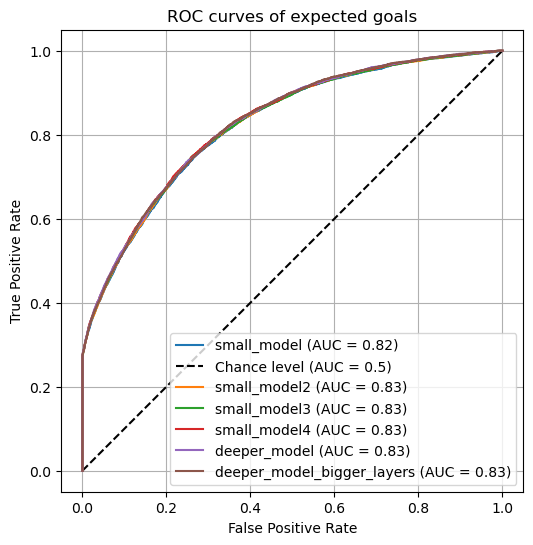

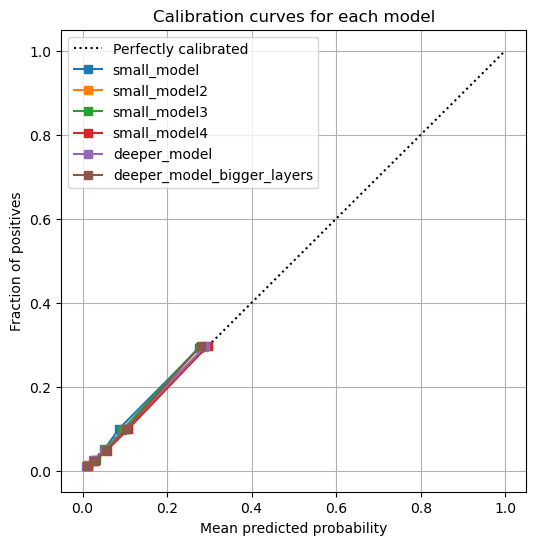

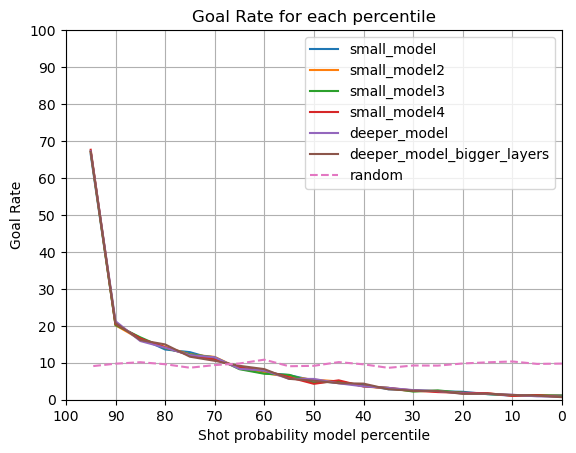

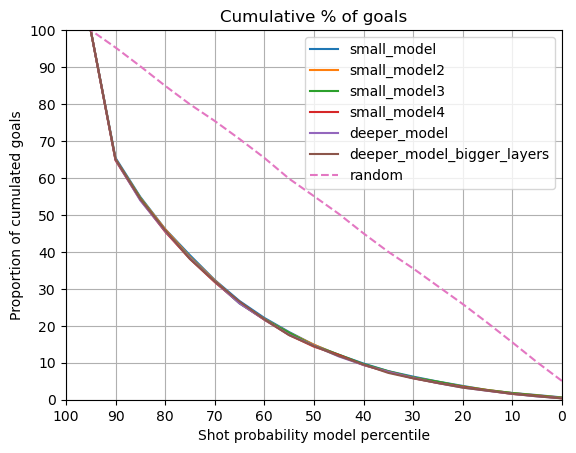

In [20]:
from ift6758.training.plot import plot_all

plot_all(models_dict, y_test.cpu().numpy(), save_to_folder="./plots")

------

# Random Forest

In [21]:
X = df.drop('is_goal', axis=1)
y = df['is_goal']

In [22]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from ift6758.training import BasicModel
from sklearn.metrics import classification_report

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)

model = BasicModel(rf_classifier)
model.train(X_train, y_train)

y_pred, accuracy = model.evaluate(X_test, y_test)
print(f"Accuracy: {accuracy:.4f}")

probabilities = model.get_pred_proba(X_test)

# model.save("random_forest_model.pkl")

print(classification_report(y_test, y_pred))

Accuracy: 0.9296
              precision    recall  f1-score   support

           0       0.93      1.00      0.96     63060
           1       0.95      0.28      0.44      6699

    accuracy                           0.93     69759
   macro avg       0.94      0.64      0.70     69759
weighted avg       0.93      0.93      0.91     69759



In [23]:
importances = rf_classifier.feature_importances_

feature_names = X_train.columns
feature_importances = pd.DataFrame(importances, index=feature_names, columns=["importance"]).sort_values("importance", ascending=False)

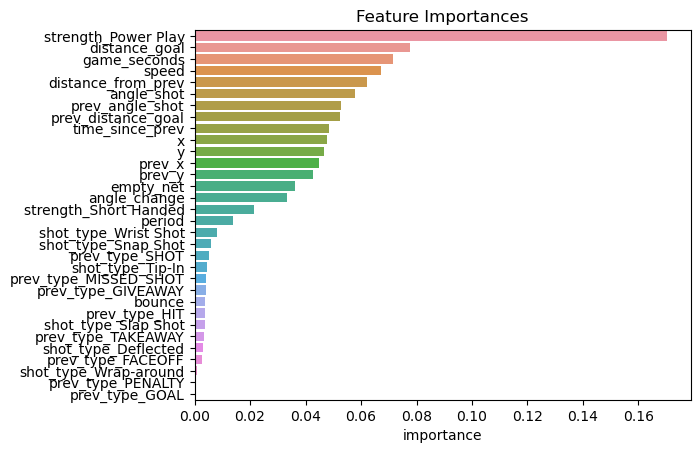

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.barplot(x="importance", y=feature_importances.index, data=feature_importances)
plt.title("Feature Importances")
plt.show()

In [ ]:
from eli5.sklearn import PermutationImportance
import eli5
perm = PermutationImportance(rf_classifier, random_state=42).fit(X_test, y_test)

eli5.show_weights(perm, feature_names = X_test.columns.tolist())

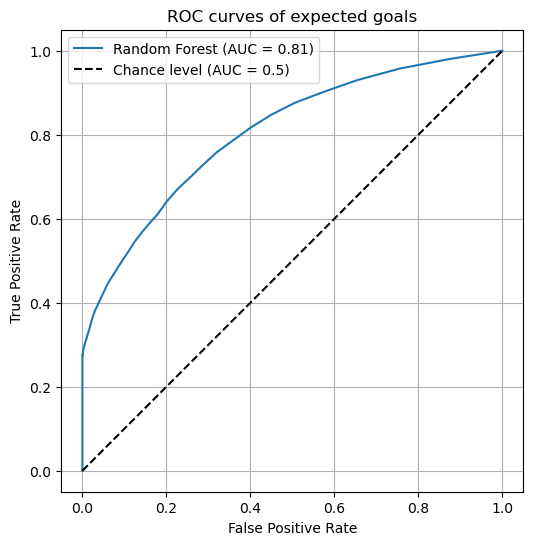

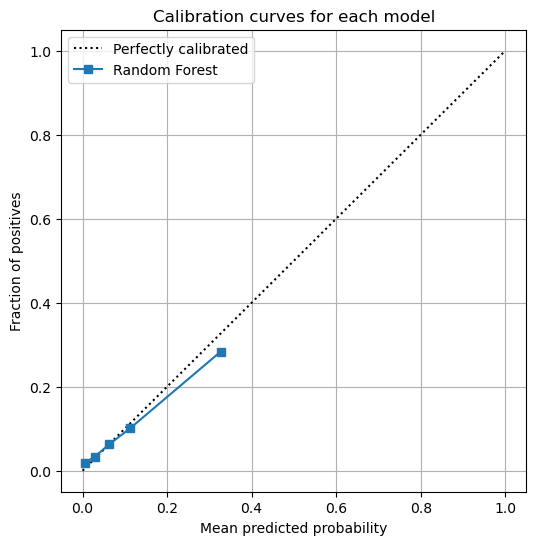

ValueError: x and y must have same first dimension, but have shapes (20,) and (15,)

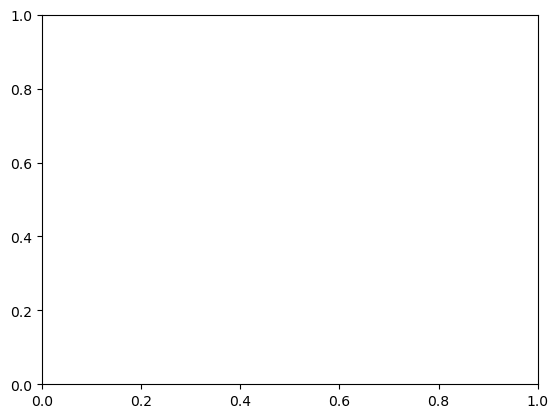

In [25]:
models_dict = {
    'Random Forest': probabilities
}

from ift6758.training.plot import plot_all

plot_all(models_dict, y_test, save_to_folder="./plots")

# Data sets division

In [26]:
from ift6758.data.cleaning import DataCleaner

data_path_clean = './../../ift6758/data/json_clean/'
data_cleaner = DataCleaner(data_raw=nhl_games_data, data_path_clean=data_path_clean)
for year in range(2016,2021):
    data_cleaner.clean_season(year, keepPreviousEventInfo=True, includePowerPlay=False)

In [27]:
dict = data_cleaner.get_team_games_seasons(2016, 2021)

In [28]:
from ift6758.features import FeatureEng
data_path_clean = './../../ift6758/data/json_clean/'
w = FeatureEng(data_path_clean)

In [29]:
df = w.features_2(2016,2021, drop_teams=False)
df.shape

(348794, 22)

### Removing first games for each team

In [30]:
w.remove_first_team_games(df, dict, 20, 10)
df.shape

(329926, 22)

In [31]:
categorical_features = ['strength', 'shot_type', 'prev_type']
df = w.encodeCategories(df, categorical_features)

### Splitting train and validation data by season

In [32]:
df['season'] = df['game_id'].astype(str).str[:4].astype(int)

train_seasons = [2016, 2017, 2018, 2019]
val_seasons = [2020]

train_df = df[df['season'].isin(train_seasons)]
val_df = df[df['season'].isin(val_seasons)]

train_df = train_df.drop(columns=['game_id', 'season', 'team'])
val_df = val_df.drop(columns=['game_id', 'season', 'team'])

In [33]:
X_train = train_df.drop('is_goal', axis=1) 
y_train = train_df['is_goal']

X_test = val_df.drop('is_goal', axis=1)
y_test = val_df['is_goal']

In [34]:
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)

model = BasicModel(rf_classifier)
model.train(X_train, y_train)

y_pred, accuracy = model.evaluate(X_test, y_test)
print(f"Accuracy: {accuracy:.4f}")

probabilities = model.get_pred_proba(X_test)

# model.save("random_forest_model.pkl")

print(classification_report(y_test, y_pred))


Accuracy: 0.9266
              precision    recall  f1-score   support

           0       0.93      1.00      0.96     45705
           1       0.94      0.27      0.42      5010

    accuracy                           0.93     50715
   macro avg       0.93      0.64      0.69     50715
weighted avg       0.93      0.93      0.91     50715



We can try normalizing the data next with MinMaxScaler(feature_range=(0, 1))